<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Function-definitions" data-toc-modified-id="Function-definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Function definitions</a></span><ul class="toc-item"><li><span><a href="#Benchmark-helper" data-toc-modified-id="Benchmark-helper-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Benchmark helper</a></span><ul class="toc-item"><li><span><a href="#Timeit-results" data-toc-modified-id="Timeit-results-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Timeit results</a></span></li><li><span><a href="#Collect" data-toc-modified-id="Collect-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Collect</a></span></li><li><span><a href="#Save-and-load" data-toc-modified-id="Save-and-load-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Save and load</a></span></li><li><span><a href="#Timing-ratios" data-toc-modified-id="Timing-ratios-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Timing ratios</a></span></li><li><span><a href="#Initialisation" data-toc-modified-id="Initialisation-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Initialisation</a></span></li></ul></li><li><span><a href="#Timed-functions" data-toc-modified-id="Timed-functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Timed functions</a></span></li><li><span><a href="#Data-set-generation-functions" data-toc-modified-id="Data-set-generation-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data set generation functions</a></span></li><li><span><a href="#Data-transformation" data-toc-modified-id="Data-transformation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data transformation</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#Runs" data-toc-modified-id="Runs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Runs</a></span><ul class="toc-item"><li><span><a href="#Example" data-toc-modified-id="Example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example</a></span></li><li><span><a href="#CommonNN-Clustering" data-toc-modified-id="CommonNN-Clustering-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CommonNN Clustering</a></span><ul class="toc-item"><li><span><a href="#Run-a" data-toc-modified-id="Run-a-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Run a</a></span></li><li><span><a href="#Run-b" data-toc-modified-id="Run-b-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Run b</a></span></li><li><span><a href="#Run-c" data-toc-modified-id="Run-c-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Run c</a></span></li><li><span><a href="#Run-c-b" data-toc-modified-id="Run-c-b-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Run c b</a></span></li><li><span><a href="#Run-c-c" data-toc-modified-id="Run-c-c-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Run c c</a></span></li><li><span><a href="#Run-d" data-toc-modified-id="Run-d-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>Run d</a></span></li><li><span><a href="#Run-d-b" data-toc-modified-id="Run-d-b-2.2.7"><span class="toc-item-num">2.2.7&nbsp;&nbsp;</span>Run d b</a></span></li><li><span><a href="#Run-d-c" data-toc-modified-id="Run-d-c-2.2.8"><span class="toc-item-num">2.2.8&nbsp;&nbsp;</span>Run d c</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-2.2.9"><span class="toc-item-num">2.2.9&nbsp;&nbsp;</span>Plots</a></span></li></ul></li></ul></li></ul></div>

# Benchmark clustering performance

Remember to compile `cnnclustering` with `TRACE_CYTHON=0` if timings should be measured.

In [1]:
from datetime import datetime
import json
from operator import itemgetter
import pathlib
import time
import timeit

import cnnclustering
from cnnclustering import cluster
from cnnclustering import _fit, _primitive_types, _types
from IPython.core.magics.execution import TimeitResult
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

In [2]:
mpl.rcParams["figure.dpi"] = 300

In [3]:
print(f"{'Python':>20} :  ", *sys.version.splitlines())

              Python :   3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27)  [GCC 9.3.0]


In [4]:
print(f"cnnclustering :  ", cnnclustering.__version__)

cnnclustering :   0.3.11


## Function definitions

### Benchmark helper

#### Timeit results

In [5]:
class TimeitResultEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, TimeitResult):
            return {
                "_type": "TimeitResult", 
                "loops": obj.loops,
                "repeat": obj.repeat,
                "best": obj.best,
                "worst": obj.worst,
                "all_runs": obj.all_runs,
                "compile_time": obj.compile_time,
                "precision": obj._precision
                }
        return super().default(self, obj)

In [6]:
class TimitResultDecoder(json.JSONDecoder):
    """Use :func:`as_TimeitResult` object hook on json load instead"""
    def default(self, obj):
        decoded_obj = super().default(self, obj)
        if isinstance(decoded_obj, list) and obj[0] == "TimeitResult":
            return TimeitResult(*obj[1].values())
        return decoded_obj

In [7]:
def as_TimeitResult(obj):
    try:
        _type = obj.pop('_type')
    except KeyError:
        _type = None

    if _type is None:
        return obj

    if _type == 'TimeitResult':
        return TimeitResult(*obj.values())

    return obj

In [8]:
def combine_timeit_results(*results):
    """Merge TimeitResults
        
    Args:
        *results: TimeitResults instances

    Returns:
        TimeitResult
        
    Note:
        Be careful about merging results from different sources.
        Merging e.g. takes the minimum number of loops done in
        each timing.
    """

    loops = min(r.loops for r in results)
    repeat = sum(r.repeat for r in results)
    all_runs = []
    for r in results:
        all_runs.extend(r.all_runs)
    best = min(all_runs)
    worst = max(all_runs)
    precision = max(r._precision for r in results)
    compile_time = max(r.compile_time for r in results)
    
    return TimeitResult(
        loops, repeat, best, worst, all_runs, compile_time, precision
        )

#### Collect

In [9]:
def collect_timings(
        gen_func, setup_func, run_arguments_list,
        transform_func=None, timings=None, repeats=10):
    """Orchestrate timings
    
    Args:
        gen_func: A function, returning data. Called with 
            run arguments "gen".
        setup_func: A function, accepting data and returning a
            function which should be timed. Called with
            run arguments "setup".
        run_argumens_list: A list of run arguments.
        
    Keyword args:
        transform_func: A function, transforming generated data before setup.
        timings: An optional timings mapping which results should
            put into.
        repeats: Repeats the timing *n* times. Using timeit -n/-r directly would
            not ensure running the setup before each timing.
    
    Returns:
        timings mapping
    """
    
    # Timed function has to be in global namespace to be discovered by %timeit magic
    global timed_args
    global timed_kwargs
    global timed_func
    
    if timings is None:
        timings = {}
    
    progress = tqdm(run_arguments_list, desc="Run completed")
    
    for run_index, arguments in enumerate(progress):
        
        gen_args, gen_kwargs = arguments.get("gen", ((), {}))
        data = gen_func(*gen_args, **gen_kwargs)
        
        if transform_func is not None:
            trans_args, trans_kwargs = arguments.get("transform", ((), {}))
            data = transform_func(data, *trans_args, **trans_kwargs)
        
        timeit_results = []
        for _ in range(repeats):
            try:
                setup_args, setup_kwargs = arguments.get("setup", ((), {}))
                timed_func = setup_func(data, *setup_args, **setup_kwargs)

                timed_args, timed_kwargs = arguments.get("timed", ((), {}))
                o = %timeit -n 1 -r 1 -q -o timed_func(*timed_args, **timed_kwargs)
            except MemoryError:
                o = "MemoryError"
                break

            finally:
                timeit_results.append(o)
        
        run_id = arguments.get("id", str(run_index))
        tqdm.write(f"Timed run ID: {run_id:>10}    ({datetime.now().strftime('%d.%m.%Y %H:%M:%S')})")
        timings[run_id] = combine_timeit_results(*timeit_results)
        
    return timings

#### Save and load

In [10]:
def save_report(timings, report_file, overwrite=False):
    report_file.parent.mkdir(exist_ok=True, parents=True)

    if report_file.is_file() and not overwrite:
        print("Report already exists. Set `overwrite = True` to force overwrite.")
        return

    with open(report_file, "w") as f:
        json.dump(timings, f, indent=4, cls=TimeitResultEncoder)

In [11]:
def load_report(report_file):

    with open(report_file) as f:
        timings = json.load(f, object_hook=as_TimeitResult)
    
    return timings

In [12]:
def add_previous_reports(timings, *previous_timings):

    for pt in previous_timings:
        for run_id, timing in pt.items():
            if run_id in timings:
                combined = combine_timeit_results(
                    timings[run_id], timing
                )
            else:
                combined = timing

            timings[run_id] = combined

#### Timing ratios

In [13]:
def get_ratios(timings, base=None, which="best"):
    """Get relative performance of runs based on timings
    
    Args:
        timinings: Timings mapping (maps run ID strings to TimeitResults)
        
    Keyword args:
        base: Use the timing for this run ID as the baseline (factor 1)
        which: Which timing should be shown ("average", "best", or "worst")
    """

    if base is not None:
        base = getattr(timings[base], which)
    else:
        base = min(
            getattr(x, which)
            for x in timings.values()
            if isinstance(x, TimeitResult)
        )

    sorted_ratios = sorted(
        [
            (k, getattr(v, which) / base)
            for k, v in timings.items()
            if isinstance(v, TimeitResult)
        ],
        key=itemgetter(1)
    )

    return sorted_ratios

In [14]:
def print_ratios(ratios):
    """Pretty print timing ratios
    
    Args:
        ratios: Ratios obtained with :func:`get_ratios` as
            list of run ID/factor tuples.
    """
    
    print(f"{'Run ID':>10}: Factor")
    print("=======================")
    for run_id, factor in ratios:
        print(f"{run_id:>10}: {factor:.2f}")

#### Initialisation

In [15]:
def make_maps():
    """Initialise benchmark setting/result mappings"""
    
    global RUN_ARGUMENTS_MAP
    global RUN_TIMINGS_MAP
    
    if "RUN_ARGUMENTS_MAP" not in dir():
        RUN_ARGUMENTS_MAP = {}

    if "RUN_TIMINGS_MAP" not in dir():
        RUN_TIMINGS_MAP = {}

In [16]:
def del_maps():
    %xdel RUN_ARGUMENTS_MAP
    %xdel RUN_TIMINGS_MAP

### Timed functions

In [17]:
def setup_sleep(data):
    """Dummy example"""

    return time.sleep

In [18]:
def setup_commonnn_clustering__fit(data, preparation_hook=cluster.prepare_pass, recipe=None):
    """Prepare benchmark of :meth:`cnnclustering.cluster.Clustering._fit`"""
    
    if recipe is None:
        recipe = {}

    clustering = cluster.prepare_clustering(data, preparation_hook, **recipe)
    clustering._labels = _types.Labels(
        np.zeros(clustering._input_data.n_points, order="C", dtype=_primitive_types.P_AINDEX)
        )

    return clustering._fit

In [19]:
def setup_commonnn_clustering_fit(data, preparation_hook=cluster.prepare_pass, recipe=None):
    """Prepare benchmark of :meth:`cnnclustering.cluster.Clustering.fit`"""
    
    if recipe is None:
        recipe = {}

    clustering = cluster.prepare_clustering(data, preparation_hook, **recipe)

    return clustering.fit

### Data set generation functions

In [20]:
def gen_dummy():
    return []

In [21]:
def gen_no_structure_points_numpy_array(size):
    rng = np.random.default_rng(2021)
    no_structure = rng.random(size)
    
    return StandardScaler().fit_transform(no_structure)

### Data transformation

In [22]:
def compute_neighbours(data, radius, sort=False):
    
    tree = KDTree(data)
    neighbourhoods = tree.query_radius(
        data, r=radius, return_distance=False
        )

    if sort:
        for n in neighbourhoods:
            n.sort()
            
    return neighbourhoods

### Plotting

In [23]:
def plot_timings(
        timings,
        ax=None,
        id_to_x=None,
        which="best",
        sort_ids=True,
        set_ax_props=True,
        ax_props=None,
        plot_props=None):
    """Plot timings
    
    Args:
        timinings: Timings mapping (maps run ID strings to TimeitResults)
    
    Keyword args:
        ax: Matplotlib axes to draw on. Will be created if `None`
        id_to_x: Optional function converting run ID strings to x-values.
        which: Which timings to show (one of "average", "best", "worst")
        sort_ids: If True, sorts timings based on run IDs.
        set_ax_props: If True, set axes properties via :meth:`ax.set`
        ax_props: Keyword args passed on to :meth:`ax.set`
        plot_props: Keyword args passed on to :meth:`ax.plot`
    """

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    if id_to_x is None:
        id_to_x = lambda x: x
        
        
    x, t = zip(
            *(
                (id_to_x(run_id), getattr(timing, which))
                for run_id, timing in timings.items()
                if isinstance(timing, TimeitResult)
            )
        )    
    x = np.asarray(x)
    t = np.asarray(t)

    if sort_ids:
        sorti = np.argsort(x)
        x = x[sorti]
        t = t[sorti]
    
    default_plot_props = {
        "linestyle": "--",
        "marker": "o",
        "markersize": 5,
        "markeredgecolor": "k"
        }
    
    if plot_props is not None:
        default_plot_props.update(plot_props)
        
    ax.plot(x, t, **default_plot_props)

    if set_ax_props:
        default_ax_props = {
            "xlim": (x[0], x[-1]),
            "xlabel": "run ID",
            "ylabel": ("time / s")
            }

        if ax_props is not None:
            default_ax_props.update(ax_props)

        ax.set(**default_ax_props)
    
    return

In [24]:
def annotate_memory_error(
        ax, line, memory_error_id):
    
    last_sample_pos = line.get_xydata()[-1]
    memory_error_pos = np.array([memory_error_id, last_sample_pos[-1]])
    ax.plot(
        *np.vstack([last_sample_pos, memory_error_pos]).T,
        color="k",
        linestyle="--",
        zorder=0
    )
    ax.plot(
        *memory_error_pos,
        color=line.get_color(),
        marker="X",
        markeredgecolor="k",
        zorder=0
    )

## Runs

### Example

In [25]:
example_run = [
    {
        "id": "1",
        "gen": (
            (), {}
        ),
        "setup": (
            (), {}
        ),
        "timed": (
            (0.1,), {
            }
        ),
    },
    {
        "id": "2",
        "gen": (
            (), {}
        ),
        "setup": (
            (), {}
        ),
        "timed": (
            (0.2,), {
            }
        ),
    }
]

sleep_timings = collect_timings(
    gen_dummy,
    setup_sleep,
    example_run
)

print()
print_ratios(get_ratios(sleep_timings))

Run completed:   0%|          | 0/2 [00:00<?, ?it/s]

Timed run ID:          1    (06.05.2021 16:49:54)
Timed run ID:          2    (06.05.2021 16:49:56)

    Run ID: Factor
         1: 1.00
         2: 2.00


In [26]:
sleep_timings

{'1': <TimeitResult : 100 ms ± 2.42 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2': <TimeitResult : 200 ms ± 3.87 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

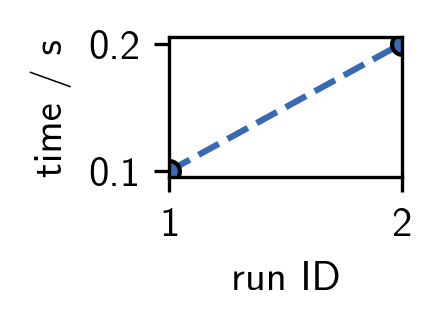

In [27]:
fig, ax = plt.subplots(figsize=(1, 1/1.618))
plot_timings(sleep_timings, ax=ax, id_to_x=lambda x: int(x))

### CommonNN Clustering

In [28]:
report_dir = pathlib.Path("reports/qcm07/cnnclustering_fit")

Clustering of a 2D toy data set (no structure) with increasing number of points while dimensionality, cluster parameters, and cluster recipe are fixed:

  - Default recipe:
    - $d = 2$, $r = 0.1$, $c = 0$ :  [run a](#run_a)
    
  - Distance recipe:
    - $d = 2$, $r = 0.1$, $c = 0$ :  [run b](#run_a)
    
  - Neighbours recipe:
    - $d = 2$, $r = 0.1$, $c = 0$ :  [run c](#run_a)
    
  - Neighbours recipe:
    - $d = 2$, $r = 0.1$, $c = 0$ :  [run d](#run_a)
    - $d = 2$, $r = 0.1$, $c = 100$ :  [run d b](#run_a_b)
    - $d = 2$, $r = 0.3$, $c = 0$ :  [run d c](#run_a_c)

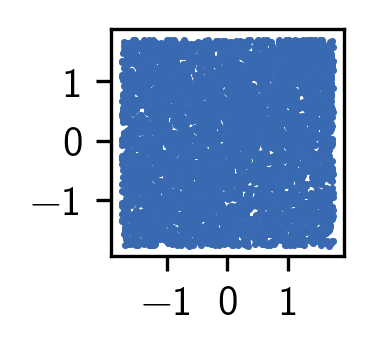

In [29]:
# The test data
fig, ax = plt.subplots(figsize=(1, 1))
ax.scatter(
    *gen_no_structure_points_numpy_array((5000, 2)).T,
    s=0.5,
    
)

In [30]:
n_points_list = [500 * 2**x for x in range(10)]

In [31]:
default_recipe = {
    "input_data": _types.InputDataExtPointsMemoryview,
    "neighbours_getter": _types.NeighboursGetterExtBruteForce,
    "neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "neighbour_neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "metric": _types.MetricExtEuclideanReduced,
    "similarity_checker": _types.SimilarityCheckerExtContains,
    "queue": _types.QueueExtFIFOQueue,
    "fitter": _fit.FitterExtBFS,
}

In [32]:
distance_recipe = {
    "input_data": _types.InputDataExtPointsMemoryview,
    "neighbours_getter": _types.NeighboursGetterExtBruteForce,
    "neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "neighbour_neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "metric": _types.MetricExtPrecomputed,
    "similarity_checker": _types.SimilarityCheckerExtContains,
    "queue": _types.QueueExtFIFOQueue,
    "fitter": _fit.FitterExtBFS,
}

In [33]:
neighbours_recipe = {
    "input_data": _types.InputDataExtNeighboursMemoryview,
    "neighbours_getter": _types.NeighboursGetterExtLookup,
    "neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "neighbour_neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "metric": _types.MetricExtDummy,
    "similarity_checker": _types.SimilarityCheckerExtContains,
    "queue": _types.QueueExtFIFOQueue,
    "fitter": _fit.FitterExtBFS,
}

In [34]:
neighbours_sorted_recipe = {
    "input_data": _types.InputDataExtNeighboursMemoryview,
    "neighbours_getter": _types.NeighboursGetterExtLookup,
    "neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "neighbour_neighbours": (_types.NeighboursExtVector, (5000,), {}),
    "metric": _types.MetricExtDummy,
    "similarity_checker": _types.SimilarityCheckerExtScreensorted,
    "queue": _types.QueueExtFIFOQueue,
    "fitter": _fit.FitterExtBFS,
}

In [35]:
make_maps()

run_name_list = [
    'no_structure_run_a',
    'no_structure_run_b',
    'no_structure_run_c',
    'no_structure_run_d',
    'no_structure_run_d_b',
    'no_structure_run_d_c',
]

for run_name in run_name_list:
    report_file = report_dir / f"{run_name}.json"
    RUN_TIMINGS_MAP[run_name] = load_report(report_file)

<a id="run_a"></a>
#### Run a

In [36]:
run_name = "no_structure_run_a"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = None
setup_func = setup_commonnn_clustering__fit

In [37]:
radius_cutoff = 0.1
cnn_cutoff = 0

RUN_ARGUMENTS_MAP[run_name] = []
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "setup": (
                (), {"recipe": default_recipe}
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [38]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_a


Run completed:   0%|          | 0/10 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 16:49:56)
Timed run ID:       1000    (06.05.2021 16:49:56)
Timed run ID:       2000    (06.05.2021 16:49:57)
Timed run ID:       4000    (06.05.2021 16:49:58)
Timed run ID:       8000    (06.05.2021 16:50:01)
Timed run ID:      16000    (06.05.2021 16:50:16)
Timed run ID:      32000    (06.05.2021 16:51:13)
Timed run ID:      64000    (06.05.2021 16:55:05)
Timed run ID:     128000    (06.05.2021 17:11:19)
Timed run ID:     256000    (06.05.2021 18:18:45)


{'500': <TimeitResult : 2.01 ms ± 259 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 7.54 ms ± 1.68 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 27.5 ms ± 9.73 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 89.4 ms ± 24.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 359 ms ± 98.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 1.43 s ± 394 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 5.72 s ± 1.57 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 23.2 s ± 6.31 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 1min 37s ± 29.4 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 6min 44s ± 2min 26s per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [39]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [40]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name]))

    Run ID: Factor
       500: 1.00
      1000: 3.84
      2000: 11.38
      4000: 45.04
      8000: 180.10
     16000: 720.78
     32000: 2884.09
     64000: 11527.52
    128000: 46168.29
    256000: 184473.71


<a id="run_b"></a>
#### Run b

In [41]:
run_name = "no_structure_run_b"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = pairwise_distances
setup_func = setup_commonnn_clustering__fit

In [42]:
radius_cutoff = 0.1
cnn_cutoff = 0

RUN_ARGUMENTS_MAP[run_name] = []
for n_points in [500 * 2**x for x in range(8)]:  # Memory error on 128000
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "setup": (
                (), {"recipe": distance_recipe}
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [43]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_b


Run completed:   0%|          | 0/8 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 18:18:45)
Timed run ID:       1000    (06.05.2021 18:18:45)
Timed run ID:       2000    (06.05.2021 18:18:46)
Timed run ID:       4000    (06.05.2021 18:18:46)
Timed run ID:       8000    (06.05.2021 18:18:52)
Timed run ID:      16000    (06.05.2021 18:19:06)
Timed run ID:      32000    (06.05.2021 18:20:06)
Timed run ID:      64000    (06.05.2021 18:24:16)


{'500': <TimeitResult : 724 µs ± 108 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 2.8 ms ± 629 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 12.7 ms ± 4.81 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 64.1 ms ± 23.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 454 ms ± 196 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 1.17 s ± 239 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 4.25 s ± 33.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 17.1 s ± 64.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [44]:
RUN_TIMINGS_MAP[run_name]["128000"] = "MemoryError"

In [45]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [46]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

    Run ID: Factor
       500: 1.00
      1000: 3.60
      2000: 11.49
      4000: 47.19
      8000: 367.65
     16000: 1498.82
     32000: 6146.07
     64000: 24953.98


<a id="run_c"></a>
#### Run c

In [47]:
run_name = "no_structure_run_c"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [48]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.1
cnn_cutoff = 0
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {}
            ),
            "setup": (
                (), {
                    "preparation_hook": cluster.prepare_neighbourhoods,
                    "recipe": neighbours_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [49]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_c


Run completed:   0%|          | 0/10 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 18:24:17)
Timed run ID:       1000    (06.05.2021 18:24:17)
Timed run ID:       2000    (06.05.2021 18:24:17)
Timed run ID:       4000    (06.05.2021 18:24:18)
Timed run ID:       8000    (06.05.2021 18:24:20)
Timed run ID:      16000    (06.05.2021 18:24:24)
Timed run ID:      32000    (06.05.2021 18:24:32)
Timed run ID:      64000    (06.05.2021 18:24:49)
Timed run ID:     128000    (06.05.2021 18:25:28)
Timed run ID:     256000    (06.05.2021 18:27:06)


{'500': <TimeitResult : 83.8 µs ± 32 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 93.1 µs ± 19.6 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 185 µs ± 92.6 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 965 µs ± 577 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 7.92 ms ± 5.55 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 13.9 ms ± 9.04 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 40.7 ms ± 8.03 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 138 ms ± 21.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 530 ms ± 70.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 2.26 s ± 259 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [50]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [51]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

    Run ID: Factor
       500: 1.00
      1000: 1.13
      2000: 1.45
      4000: 2.68
      8000: 26.48
     16000: 81.55
     32000: 409.02
     64000: 1472.91
    128000: 5848.36
    256000: 25515.87


<a id="run_c_b"></a>
#### Run c b

In [52]:
run_name = "no_structure_run_c_b"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [53]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.1
cnn_cutoff = 100
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {}
            ),
            "setup": (
                (), {
                    "preparation_hook": cluster.prepare_neighbourhoods,
                    "recipe": neighbours_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [54]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_c_b


Run completed:   0%|          | 0/10 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 18:27:06)
Timed run ID:       1000    (06.05.2021 18:27:07)
Timed run ID:       2000    (06.05.2021 18:27:07)
Timed run ID:       4000    (06.05.2021 18:27:08)
Timed run ID:       8000    (06.05.2021 18:27:10)
Timed run ID:      16000    (06.05.2021 18:27:13)
Timed run ID:      32000    (06.05.2021 18:27:21)
Timed run ID:      64000    (06.05.2021 18:30:14)
Timed run ID:     128000    (06.05.2021 18:31:14)
Timed run ID:     256000    (06.05.2021 18:33:43)


{'500': <TimeitResult : 73.3 µs ± 7.55 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 82.6 µs ± 2.25 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 106 µs ± 952 ns per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 182 µs ± 3.08 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 481 µs ± 103 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 1.54 ms ± 134 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 24.3 ms ± 26.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 15.7 s ± 2.49 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 2.54 s ± 409 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 7.16 s ± 329 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [55]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [56]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

    Run ID: Factor
       500: 1.00
      1000: 1.14
      2000: 1.48
      4000: 2.56
      8000: 6.30
     16000: 21.03
     32000: 89.47
    128000: 29191.25
    256000: 94533.45
     64000: 168392.29


<a id="run_c_c"></a>
#### Run c c

In [57]:
run_name = "no_structure_run_c_c"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [58]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.3
cnn_cutoff = 0
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {}
            ),
            "setup": (
                (), {
                    "preparation_hook": cluster.prepare_neighbourhoods,
                    "recipe": neighbours_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [59]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_c_c


Run completed:   0%|          | 0/10 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 18:33:43)
Timed run ID:       1000    (06.05.2021 18:33:44)
Timed run ID:       2000    (06.05.2021 18:33:44)
Timed run ID:       4000    (06.05.2021 18:33:45)
Timed run ID:       8000    (06.05.2021 18:33:47)
Timed run ID:      16000    (06.05.2021 18:33:52)
Timed run ID:      32000    (06.05.2021 18:34:05)
Timed run ID:      64000    (06.05.2021 18:34:46)
Timed run ID:     128000    (06.05.2021 18:37:36)
Timed run ID:     256000    (06.05.2021 18:54:39)


{'500': <TimeitResult : 187 µs ± 76.8 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 1.09 ms ± 855 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 1.59 ms ± 722 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 4.27 ms ± 919 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 16.7 ms ± 2.68 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 72 ms ± 9.88 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 355 ms ± 42.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 1.84 s ± 189 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 10.8 s ± 892 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 1min 17s ± 4.69 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [60]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [61]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

    Run ID: Factor
       500: 1.00
      1000: 3.46
      2000: 10.44
      4000: 36.08
      8000: 155.47
     16000: 704.80
     32000: 3539.87
     64000: 18977.51
    128000: 115620.64
    256000: 863166.43


<a id="run_d"></a>
#### Run d

In [62]:
run_name = "no_structure_run_d"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [63]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.1
cnn_cutoff = 0
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": cluster.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [64]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_d


Run completed:   0%|          | 0/10 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 18:54:40)
Timed run ID:       1000    (06.05.2021 18:54:40)
Timed run ID:       2000    (06.05.2021 18:54:41)
Timed run ID:       4000    (06.05.2021 18:54:42)
Timed run ID:       8000    (06.05.2021 18:54:44)
Timed run ID:      16000    (06.05.2021 18:54:48)
Timed run ID:      32000    (06.05.2021 18:54:55)
Timed run ID:      64000    (06.05.2021 18:55:13)
Timed run ID:     128000    (06.05.2021 18:55:51)
Timed run ID:     256000    (06.05.2021 18:57:25)


{'500': <TimeitResult : 81.9 µs ± 25.6 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 94.6 µs ± 17.3 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 208 µs ± 126 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 774 µs ± 427 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 5.18 ms ± 3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 9.47 ms ± 3.72 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 30.8 ms ± 3.11 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 102 ms ± 6.33 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 365 ms ± 12.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 1.27 s ± 24.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [65]:
previous_timings = load_report(report_file)
for run_id, timing in previous_timings.items():
    if run_id in RUN_TIMINGS_MAP[run_name]:
        combined = combine_timeit_results(
            RUN_TIMINGS_MAP[run_name][run_id], timing
        )
    else:
        combined = timing
        
    RUN_TIMINGS_MAP[run_name][run_id] = combined

In [66]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [67]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

    Run ID: Factor
       500: 1.00
      1000: 1.14
      2000: 1.50
      4000: 2.67
      8000: 22.84
     16000: 80.77
     32000: 359.05
     64000: 1280.41
    128000: 4773.54
    256000: 17251.74


<a id="run_d_b"></a>
#### Run d b

In [68]:
run_name = "no_structure_run_d_b"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [69]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.1
cnn_cutoff = 100
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": cluster.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [70]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_d_b


Run completed:   0%|          | 0/10 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 18:57:25)
Timed run ID:       1000    (06.05.2021 18:57:25)
Timed run ID:       2000    (06.05.2021 18:57:26)
Timed run ID:       4000    (06.05.2021 18:57:27)
Timed run ID:       8000    (06.05.2021 18:57:28)
Timed run ID:      16000    (06.05.2021 18:57:32)
Timed run ID:      32000    (06.05.2021 18:57:40)
Timed run ID:      64000    (06.05.2021 18:58:22)
Timed run ID:     128000    (06.05.2021 18:59:04)
Timed run ID:     256000    (06.05.2021 19:00:43)


{'500': <TimeitResult : 78.8 µs ± 9.26 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 88 µs ± 11 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 109 µs ± 4.72 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 185 µs ± 3.57 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 452 µs ± 9.96 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 1.5 ms ± 14.5 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 11.1 ms ± 6.44 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 2.65 s ± 443 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 625 ms ± 37.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 1.71 s ± 26.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [71]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [72]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

    Run ID: Factor
       500: 1.00
      1000: 1.10
      2000: 1.43
      4000: 2.43
      8000: 5.96
     16000: 19.97
     32000: 87.27
    128000: 7739.12
    256000: 22501.85
     64000: 26586.38


<a id="run_d_c"></a>
#### Run d c

In [73]:
run_name = "no_structure_run_d_c"
report_file = report_dir / f"{run_name}.json"

gen_func = gen_no_structure_points_numpy_array
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [74]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.3
cnn_cutoff = 0
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": cluster.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [75]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

Collection for run: no_structure_run_d_c


Run completed:   0%|          | 0/10 [00:00<?, ?it/s]

Timed run ID:        500    (06.05.2021 19:00:43)
Timed run ID:       1000    (06.05.2021 19:00:43)
Timed run ID:       2000    (06.05.2021 19:00:44)
Timed run ID:       4000    (06.05.2021 19:00:45)
Timed run ID:       8000    (06.05.2021 19:00:47)
Timed run ID:      16000    (06.05.2021 19:00:52)
Timed run ID:      32000    (06.05.2021 19:01:03)
Timed run ID:      64000    (06.05.2021 19:01:34)
Timed run ID:     128000    (06.05.2021 19:03:09)
Timed run ID:     256000    (06.05.2021 19:08:48)


{'500': <TimeitResult : 163 µs ± 58.9 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 747 µs ± 484 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 1.08 ms ± 309 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 2.97 ms ± 398 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 10.1 ms ± 666 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 39.4 ms ± 1.34 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 150 ms ± 3.93 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 566 ms ± 6.94 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 2.2 s ± 10.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 8.99 s ± 26.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [76]:
save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [77]:
print_ratios(get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

    Run ID: Factor
       500: 1.00
      1000: 3.58
      2000: 8.80
      4000: 30.28
      8000: 113.11
     16000: 464.12
     32000: 1816.65
     64000: 6954.94
    128000: 27366.46
    256000: 112138.82


#### Plots

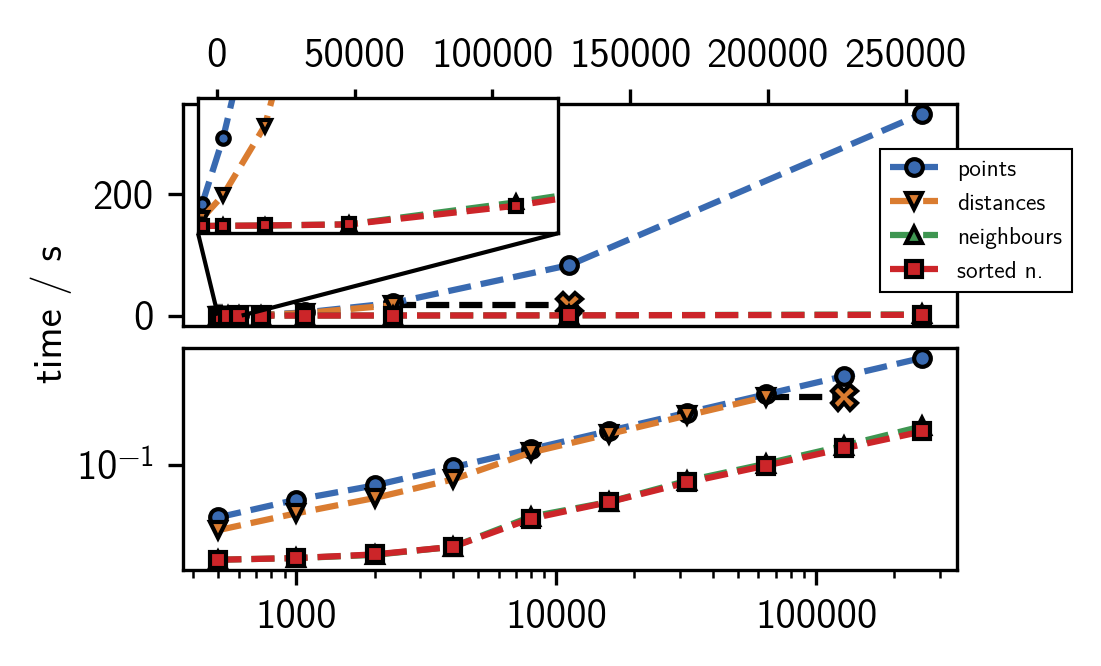

In [78]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33/1.618))

run_name_list = [
    ('no_structure_run_a', 'points'),
    ('no_structure_run_b', 'distances'),
    ('no_structure_run_c', 'neighbours'),
    ('no_structure_run_d', 'sorted n.'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

# Inset
inset_ax = fig.add_axes(
    [0.14, 0.67, 0.36, 0.22],
    zorder=3,
    )

for name, label in run_name_list:
    marker = next(markers)
    
    plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
    line = normal_ax.lines[-1]
    inset_line, = inset_ax.plot(*line.get_xydata().T)
    saved_transform = inset_line.get_transform()
    saved_clipbox = inset_line.clipbox
    inset_line.update_from(line)
    inset_line.set_transform(saved_transform)
    inset_line.clipbox = saved_clipbox
    
    inset_line.set_markersize(3)
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

inset_ax.set(**{
    "xlim": (400, 9000),
    "ylim": (-0.0005, 0.01),
    "xticks": (),
    "yticks": (),
})

mark_inset(normal_ax, inset_ax, loc1=3, loc2=4, edgecolor="k")

# Annotate memory error
annotate_memory_error(
    ax=normal_ax, line=normal_ax.get_lines()[1],
    memory_error_id=128000
)
annotate_memory_error(
    ax=log_ax, line=log_ax.get_lines()[1],
    memory_error_id=128000
)
    
commonax = fig.add_axes(
    [0.03, 0.08, 0.97, 0.92],
    zorder=-1,
    frame_on=False
    )

commonax.set(**{
    "ylabel": "time / s",
    "xticks": (),
    "yticks": ()
})

# Legend
legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0.9, 0.15)
    )
legend.get_frame().set_linewidth(0.5)

log_ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

fig.subplots_adjust(hspace=0.1)

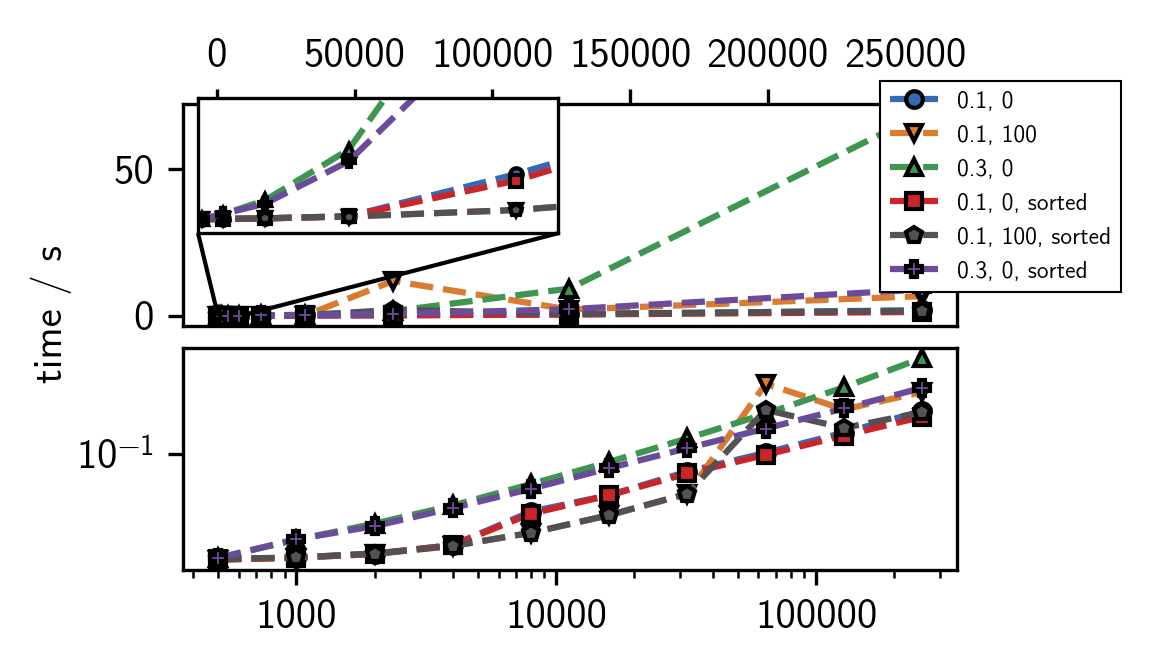

In [79]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33/1.618))

run_name_list = [
    ('no_structure_run_c', '0.1, 0'),
    ('no_structure_run_c_b', '0.1, 100'),
    ('no_structure_run_c_c', '0.3, 0'),
    ('no_structure_run_d', '0.1, 0, sorted'),
    ('no_structure_run_d_b', '0.1, 100, sorted'),
    ('no_structure_run_d_c', '0.3, 0, sorted'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

# Inset
inset_ax = fig.add_axes(
    [0.14, 0.67, 0.36, 0.22],
    zorder=3,
    )

for name, label in run_name_list:
    marker = next(markers)
    
    plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
    line = normal_ax.lines[-1]
    inset_line, = inset_ax.plot(*line.get_xydata().T)
    saved_transform = inset_line.get_transform()
    saved_clipbox = inset_line.clipbox
    inset_line.update_from(line)
    inset_line.set_transform(saved_transform)
    inset_line.clipbox = saved_clipbox
    
    inset_line.set_markersize(3)
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

inset_ax.set(**{
    "xlim": (400, 9000),
    "ylim": (-0.0005, 0.005),
    "xticks": (),
    "yticks": (),
})

mark_inset(normal_ax, inset_ax, loc1=3, loc2=4, edgecolor="k")
    
commonax = fig.add_axes(
    [0.03, 0.08, 0.97, 0.92],
    zorder=-1,
    frame_on=False
    )

commonax.set(**{
    "ylabel": "time / s",
    "xticks": (),
    "yticks": ()
})

# Legend
legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0.9, 0.15)
    )
legend.get_frame().set_linewidth(0.5)

log_ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

fig.subplots_adjust(hspace=0.1)